# ShuffleNetV1实现食物识别
该项目可以实现判断食品的种类，包括13种食物，分别是："bhaji", "chapati", "githeri", "kachumbari", "kukuchoma", "mandazi", "masalachips", "matoke", "mukimo", "nyamachoma","pilau", "sukumawiki", "ugali"。

In [1]:
%%capture captured_output
# 实验环境已经预装了mindspore==2.5.0，如需更换mindspore版本，可更改下面 MINDSPORE_VERSION 变量
!pip uninstall mindspore -y
%env MINDSPORE_VERSION=2.5.0
!pip install https://ms-release.obs.cn-north-4.myhuaweicloud.com/${MINDSPORE_VERSION}/MindSpore/unified/aarch64/mindspore-${MINDSPORE_VERSION}-cp39-cp39-linux_aarch64.whl --trusted-host ms-release.obs.cn-north-4.myhuaweicloud.com -i https://pypi.tuna.tsinghua.edu.cn/simple

In [2]:
# 查看当前 mindspore 版本
!pip show mindspore

Name: mindspore
Version: 2.5.0
Summary: MindSpore is a new open source deep learning training/inference framework that could be used for mobile, edge and cloud scenarios.
Home-page: https://www.mindspore.cn
Author: The MindSpore Authors
Author-email: contact@mindspore.cn
License: Apache 2.0
Location: /home/mindspore/miniconda/envs/jupyter/lib/python3.9/site-packages
Requires: asttokens, astunparse, dill, numpy, packaging, pillow, protobuf, psutil, safetensors, scipy
Required-by: 


In [11]:
!git lfs install
!git clone https://modelers.cn/xsir/foods.git
!unzip -q foods/dataset.zip -d ./foods/

Git LFS initialized.
正克隆到 'foods'...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 7 (delta 1), reused 0 (delta 0), pack-reused 0
接收对象中: 100% (7/7), 完成.
处理 delta 中: 100% (1/1), 完成.


In [3]:
import os

import mindspore as ms
from mindspore.dataset import ImageFolderDataset
import mindspore.dataset.vision as transforms


data_path = './foods/Food13/'
mean = [0.485 * 255, 0.456 * 255, 0.406 * 255]
std = [0.229 * 255, 0.224 * 255, 0.225 * 255]

dataset_train = ImageFolderDataset(os.path.join(data_path, "train"), shuffle=True)

trans_train = [
    transforms.RandomCropDecodeResize(size=224,
                                      scale=(0.08, 1.0),
                                      ratio=(0.75, 1.333)),
    transforms.RandomHorizontalFlip(prob=0.5),
    transforms.Normalize(mean=mean, std=std),
    transforms.HWC2CHW()
]

dataset_train = dataset_train.map(operations=trans_train, input_columns=["image"])
dataset_train = dataset_train.batch(batch_size=16, drop_remainder=True)

/home/mindspore/miniconda/envs/jupyter/lib/python3.9/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/mindspore/miniconda/envs/jupyter/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/mindspore/miniconda/envs/jupyter/lib/python3.9/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/mindspore/miniconda/envs/jupyter/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


## ShuffleNetV1模型架构

In [4]:
"""ShuffleNetV1"""
import mindspore.nn as nn
import mindspore.ops.operations as P
from mindspore import dtype as mstype


class GroupConv(nn.Cell):
    """
    group convolution operation.

    Args:
        in_channels (int): Input channels of feature map.
        out_channels (int): Output channels of feature map.
        kernel_size (int): Size of convolution kernel.
        stride (int): Stride size for the group convolution layer.

    Returns:
        tensor, output tensor.
    """

    def __init__(self, in_channels, out_channels, kernel_size, stride, pad_mode="pad", pad=0, groups=1, has_bias=False):
        super(GroupConv, self).__init__()
        assert in_channels % groups == 0 and out_channels % groups == 0
        self.groups = groups
        self.convs = nn.CellList()
        self.op_split = P.Split(axis=1, output_num=self.groups)
        self.op_concat = P.Concat(axis=1)
        self.cast = P.Cast()
        for _ in range(groups):
            self.convs.append(nn.Conv2d(in_channels // groups, out_channels // groups,
                                        kernel_size=kernel_size, stride=stride, has_bias=has_bias,
                                        padding=pad, pad_mode=pad_mode, group=1, weight_init='xavier_uniform'))

    def construct(self, x):
        features = self.op_split(x)
        outputs = ()
        for i in range(self.groups):
            outputs = outputs + (self.convs[i](self.cast(features[i], mstype.float32)),)
        out = self.op_concat(outputs)
        return out


class ShuffleV1Block(nn.Cell):
    def __init__(self, inp, oup, group, first_group, mid_channels, ksize, stride):
        super(ShuffleV1Block, self).__init__()
        self.stride = stride

        pad = ksize // 2
        self.group = group

        if stride == 2:
            outputs = oup - inp
        else:
            outputs = oup

        self.relu = nn.ReLU()
        self.add = P.Add()
        self.concat = P.Concat(1)
        self.shape = P.Shape()
        self.transpose = P.Transpose()
        self.reshape = P.Reshape()

        branch_main_1 = [
            # pw
            GroupConv(in_channels=inp, out_channels=mid_channels, kernel_size=1, stride=1, pad_mode="pad", pad=0,
                      groups=1 if first_group else group),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(),
        ]

        branch_main_2 = [
            # dw
            nn.Conv2d(mid_channels, mid_channels, kernel_size=ksize, stride=stride, pad_mode='pad', padding=pad,
                      group=mid_channels, weight_init='xavier_uniform', has_bias=False),
            nn.BatchNorm2d(mid_channels),
            # pw
            GroupConv(in_channels=mid_channels, out_channels=outputs, kernel_size=1, stride=1, pad_mode="pad", pad=0,
                      groups=group),
            nn.BatchNorm2d(outputs),
        ]
        self.branch_main_1 = nn.SequentialCell(branch_main_1)
        self.branch_main_2 = nn.SequentialCell(branch_main_2)
        if stride == 2:
            self.branch_proj = nn.AvgPool2d(kernel_size=3, stride=2, pad_mode='same')

    def construct(self, old_x):
        left = old_x
        right = old_x
        out = old_x
        right = self.branch_main_1(right)
        if self.group > 1:
            right = self.channel_shuffle(right)
        right = self.branch_main_2(right)
        if self.stride == 1:
            out = self.relu(self.add(left, right))
        elif self.stride == 2:
            left = self.branch_proj(left)
            out = self.concat((left, right))
            out = self.relu(out)
        return out

    def channel_shuffle(self, x):
        batchsize, num_channels, height, width = self.shape(x)
        group_channels = num_channels // self.group
        x = self.reshape(x, (batchsize, group_channels, self.group, height, width))
        x = self.transpose(x, (0, 2, 1, 3, 4))
        x = self.reshape(x, (batchsize, num_channels, height, width))
        return x


class ShuffleNetV1(nn.Cell):
    def __init__(self, n_class=1000, model_size='2.0x', group=3):
        super(ShuffleNetV1, self).__init__()
        print('model size is ', model_size)

        self.stage_repeats = [4, 8, 4]
        self.model_size = model_size
        if group == 3:
            if model_size == '0.5x':
                self.stage_out_channels = [-1, 12, 120, 240, 480]
            elif model_size == '1.0x':
                self.stage_out_channels = [-1, 24, 240, 480, 960]
            elif model_size == '1.5x':
                self.stage_out_channels = [-1, 24, 360, 720, 1440]
            elif model_size == '2.0x':
                self.stage_out_channels = [-1, 48, 480, 960, 1920]
            else:
                raise NotImplementedError
        elif group == 8:
            if model_size == '0.5x':
                self.stage_out_channels = [-1, 16, 192, 384, 768]
            elif model_size == '1.0x':
                self.stage_out_channels = [-1, 24, 384, 768, 1536]
            elif model_size == '1.5x':
                self.stage_out_channels = [-1, 24, 576, 1152, 2304]
            elif model_size == '2.0x':
                self.stage_out_channels = [-1, 48, 768, 1536, 3072]
            else:
                raise NotImplementedError

        # building first layer
        input_channel = self.stage_out_channels[1]
        self.first_conv = nn.SequentialCell(
            nn.Conv2d(3, input_channel, 3, 2, 'pad', 1, weight_init='xavier_uniform', has_bias=False),
            nn.BatchNorm2d(input_channel),
            nn.ReLU(),
        )
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, pad_mode='same')

        features = []
        for idxstage in range(len(self.stage_repeats)):
            numrepeat = self.stage_repeats[idxstage]
            output_channel = self.stage_out_channels[idxstage + 2]

            for i in range(numrepeat):
                stride = 2 if i == 0 else 1
                first_group = idxstage == 0 and i == 0
                features.append(ShuffleV1Block(input_channel, output_channel,
                                               group=group, first_group=first_group,
                                               mid_channels=output_channel // 4, ksize=3, stride=stride))
                input_channel = output_channel

        self.features = nn.SequentialCell(features)
        self.globalpool = nn.AvgPool2d(7)
        self.classifier = nn.Dense(self.stage_out_channels[-1], n_class)
        self.reshape = P.Reshape()

    def construct(self, x):
        x = self.first_conv(x)
        x = self.maxpool(x)
        x = self.features(x)
        x = self.globalpool(x)
        x = self.reshape(x, (-1, self.stage_out_channels[-1]))
        x = self.classifier(x)
        return x


## 模型训练与推理

### 模型训练

模型开始训练前，需要设定损失函数，优化器，回调函数等。

完整训练该模型需要很长的时间，实际应用时建议根据项目需要调整epoch_size，当正常输出每个Epoch的step信息时，意味着训练正在进行，通过模型输出可以查看当前训练的loss值和时间等指标。

In [5]:
# 定义网络
network = ShuffleNetV1(n_class=13)

model size is  2.0x


In [6]:
%%time
from mindspore.nn import LossBase
from mindspore.train import LossMonitor, TimeMonitor, CheckpointConfig, ModelCheckpoint
from mindspore import train, ops

# define super parameter
epoch_size = 20
momentum = 0.9
num_classes = 13
resize = 224
step_size = dataset_train.get_dataset_size()


# define learning rate
lr = nn.cosine_decay_lr(min_lr=float(0),
                        max_lr=0.00005,
                        total_step=epoch_size * step_size,
                        step_per_epoch=step_size,
                        decay_epoch=10)

# define optimizer
network_opt = nn.Adam(network.trainable_params(), lr, momentum)


# define loss function
class CrossEntropySmooth(LossBase):
    """CrossEntropy."""

    def __init__(self, sparse=True, reduction='mean', smooth_factor=0., num_classes=1000):
        super(CrossEntropySmooth, self).__init__()
        self.onehot = ops.OneHot()
        self.sparse = sparse
        self.on_value = ms.Tensor(1.0 - smooth_factor, ms.float32)
        self.off_value = ms.Tensor(1.0 * smooth_factor / (num_classes - 1), ms.float32)
        self.ce = nn.SoftmaxCrossEntropyWithLogits(reduction=reduction)

    def construct(self, logit, label):
        if self.sparse:
            label = self.onehot(label, ops.shape(logit)[1], self.on_value, self.off_value)
        loss = self.ce(logit, label)
        return loss


network_loss = CrossEntropySmooth(sparse=True,
                                  reduction="mean",
                                  smooth_factor=0.1,
                                  num_classes=num_classes)

# set checkpoint
ckpt_config = CheckpointConfig(save_checkpoint_steps=step_size, keep_checkpoint_max=5)
ckpt_callback = ModelCheckpoint(prefix='InceptionResnetV2', directory='./InceptionResnetV2', config=ckpt_config)

# initialize model
# "Ascend + mixed precision" can improve performance
#ascend_target = (ms.get_context("device_target") == "Ascend")
ascend_target = False
if ascend_target:
    model = train.Model(network, loss_fn=network_loss, optimizer=network_opt, metrics={"acc"}, amp_level="O2")
else:
    model = train.Model(network, loss_fn=network_loss, optimizer=network_opt, metrics={"acc"}, amp_level="O0")

# train model
model.train(epoch_size,
            dataset_train,
            callbacks=[ckpt_callback, LossMonitor(125), TimeMonitor(125)],
            dataset_sink_mode=False,)

[WARNING] DEVICE(116282,ffffa3d61020,python):2025-03-12-09:37:36.188.015 [mindspore/ccsrc/plugin/device/ascend/hal/device/ascend_memory_adapter.cc:118] Initialize] Free memory size is less than half of total memory size.Device 0 Device MOC total size:34359738368 Device MOC free size:1876418560 may be other processes occupying this card, check as: ps -ef|grep python
/usr/local/Ascend/ascend-toolkit/8.0.0/opp/built-in/op_impl/ai_core/tbe/impl/util/util_conv2d_dynamic.py:130: UserWarning: conv2d fmap ori_range changed from [[16, 31], [48, 48], [16, 63], [16, 63]] to [[16, 31], [48, 48], [16, 63], (16, 63)].
  warnings.warn(to_print)
/usr/local/Ascend/ascend-toolkit/8.0.0/opp/built-in/op_impl/ai_core/tbe/impl/util/util_conv2d_dynamic.py:130: UserWarning: conv2d fmap ori_range changed from [[16, 31], [480, 480], [16, 63], [16, 63]] to [[16, 31], [480, 480], [16, 63], (16, 63)].
  warnings.warn(to_print)
/usr/local/Ascend/ascend-toolkit/8.0.0/opp/built-in/op_impl/ai_core/tbe/impl/util/util_c

...epoch: 1 step: 125, loss is 2.3783082962036133
epoch: 1 step: 250, loss is 2.242788553237915
epoch: 1 step: 375, loss is 2.055560350418091
Train epoch time: 145671.253 ms, per step time: 357.037 ms
epoch: 2 step: 92, loss is 2.1758623123168945
epoch: 2 step: 217, loss is 2.237833023071289
epoch: 2 step: 342, loss is 2.3489129543304443
Train epoch time: 98090.585 ms, per step time: 240.418 ms
epoch: 3 step: 59, loss is 2.3435816764831543
epoch: 3 step: 184, loss is 1.9976708889007568
epoch: 3 step: 309, loss is 2.05312442779541
Train epoch time: 97570.327 ms, per step time: 239.143 ms
epoch: 4 step: 26, loss is 2.229548215866089
epoch: 4 step: 151, loss is 1.9005229473114014
epoch: 4 step: 276, loss is 1.8958996534347534
epoch: 4 step: 401, loss is 2.18746280670166
Train epoch time: 96225.854 ms, per step time: 235.848 ms
epoch: 5 step: 118, loss is 2.4159703254699707
epoch: 5 step: 243, loss is 1.7170437574386597
epoch: 5 step: 368, loss is 1.965646743774414
Train epoch time: 96952.

### 模型验证

模型验证过程主要应用了ImageFolderDataset，CrossEntropySmooth和Model等接口。

ImageFolderDataset主要用于读取数据集。

CrossEntropySmooth是损失函数实例化接口。

Model主要用于编译模型。

与训练过程相似，首先进行数据增强，然后定义ShuffleNetV1网络结构，加载预训练模型参数。随后设置损失函数，评价指标等，编译模型后进行验证。本案例采用了业界通用的评价标准Top_1_Accuracy评价指标来评价模型表现。

In [9]:
dataset_val = ImageFolderDataset(os.path.join(data_path, "val"), shuffle=True)

trans_val = [
    transforms.Decode(),
    transforms.Resize(224 + 32),
    transforms.CenterCrop(224),
    transforms.Normalize(mean=mean, std=std),
    transforms.HWC2CHW()
]

dataset_val = dataset_val.map(operations=trans_val, input_columns=["image"])
dataset_val = dataset_val.batch(batch_size=16, drop_remainder=True)

network_loss = CrossEntropySmooth(sparse=True,
                                  reduction="mean",
                                  smooth_factor=0.1,
                                  num_classes=num_classes)

# define metric
eval_metrics = {'Top_1_Accuracy': train.Top1CategoricalAccuracy()}

if ascend_target:
    model = train.Model(network, loss_fn=network_loss, optimizer=network_opt, metrics=eval_metrics, amp_level="O2")
else:
    model = train.Model(network, loss_fn=network_loss, optimizer=network_opt, metrics=eval_metrics, amp_level="O0")

# evaluate model
result = model.eval(dataset_val)
print(result)

{'Top_1_Accuracy': 0.4068627450980392}


### 模型推理


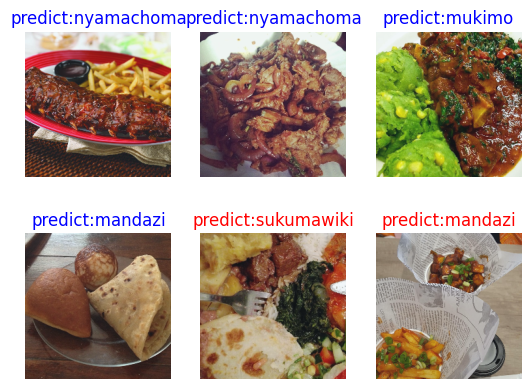

In [10]:
import matplotlib.pyplot as plt
import numpy as np
data = next(dataset_val.create_dict_iterator())
images = data["image"]
labels = data["label"]
output = network(data['image'])
pred = np.argmax(output.asnumpy(), axis=1)

# 图像分类
classes = ["bhaji", "chapati", "githeri", "kachumbari", "kukuchoma",
          "mandazi", "masalachips", "matoke", "mukimo", "nyamachoma",
          "pilau", "sukumawiki", "ugali"]

# 显示图像及图像的预测值
plt.figure()
for i in range(6):
    plt.subplot(2, 3, i + 1)
    # 若预测正确，显示为蓝色；若预测错误，显示为红色
    color = 'blue' if pred[i] == labels.asnumpy()[i] else 'red'
    plt.title('predict:{}'.format(classes[pred[i]]), color=color)
    picture_show = np.transpose(images.asnumpy()[i], (1, 2, 0))
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2023, 0.1994, 0.2010])
    picture_show = std * picture_show + mean
    picture_show = np.clip(picture_show, 0, 1)
    plt.imshow(picture_show)
    plt.axis('off')

plt.show()